In [113]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import statsmodels.api as sm
from scipy.stats import norm
import matplotlib.pyplot as plt

# --- Load ---
ff_factors   = pd.read_csv("FactorData.csv")
crsp_monthly = pd.read_csv("monthlyData.csv")

ff_factors['date']      = pd.to_datetime(ff_factors['date'])
crsp_monthly['MthCalDt'] = pd.to_datetime(crsp_monthly['MthCalDt'])

# Normalize FF column names
ff_factors.columns = [c.lower().replace(' ', '') for c in ff_factors.columns]
ff_factors.rename(columns={'mkt-rf':'mktrf', 'mom':'umd'}, inplace=True)

FACTOR_COLS = ['mktrf','smb','hml','rmw','cma','umd']

# Ensure numeric
for c in FACTOR_COLS + ['rf']:
    ff_factors[c] = pd.to_numeric(ff_factors[c], errors='coerce')
crsp_monthly['MthRet'] = pd.to_numeric(crsp_monthly['MthRet'], errors='coerce')

# --- DAILY → MONTHLY (correct) ---
g = ff_factors.set_index('date').groupby(pd.Grouper(freq='M'))
ff_monthly = g[FACTOR_COLS].sum(min_count=1)
ff_monthly['rf'] = g['rf'].apply(lambda s: (1.0 + s.dropna()).prod() - 1.0)
ff_monthly = ff_monthly.reset_index().rename(columns={'date':'MthCalDt'})

# --- Align to month-end key and MERGE (avoid duplicate MthCalDt) ---
crsp_key = crsp_monthly['MthCalDt'].dt.to_period('M').dt.to_timestamp('M')
ff_key   = ff_monthly['MthCalDt'].dt.to_period('M').dt.to_timestamp('M')

df = (
    crsp_monthly
      .assign(M_end=crsp_key)               # month-end key
      .drop(columns=['MthCalDt'])           # drop original to avoid duplicate later
      .merge(
          ff_monthly.assign(M_end=ff_key).drop(columns=['MthCalDt']),
          on='M_end', how='inner'
      )
      .rename(columns={'M_end':'MthCalDt'})  # single, clean date column
      .sort_values(['MthCalDt','Ticker'])
      .set_index('MthCalDt')
)

# Sanity: no duplicate columns and reasonable scales
assert not df.columns.duplicated().any(), "Duplicate column names present"
print(df[['MthRet','mktrf','rf']].describe())

# Build excess return for later steps (regimes/rolling, etc.)
df['excess_ret'] = df['MthRet'] - df['rf']
df.head()

C:\Users\creat\AppData\Local\Temp\ipykernel_26408\3256214548.py:27: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  g = ff_factors.set_index('date').groupby(pd.Grouper(freq='M'))


            MthRet        mktrf           rf
count  1185.000000  1185.000000  1185.000000
mean      0.008812     0.011764     0.000982
std       0.049877     0.043652     0.001462
min      -0.214809    -0.106700     0.000000
25%      -0.022581    -0.015300     0.000000
50%       0.010501     0.016300     0.000200
75%       0.038202     0.038000     0.001611
max       0.182442     0.135100     0.004851


,PERMNO,HdrCUSIP,Ticker,PERMCO,MthPrc,MthRet,MthVol,ShrOut,DisFacPr,vwretd,mktrf,smb,hml,rmw,cma,umd,rf,excess_ret
MthCalDt,,,,,,,,,,,,,,,,,,
2009-01-31,89730,46428723,EEM,37493,22.65,-0.092911,1646884500,782550,NaN,-0.077471,-0.0789,-0.0203,-0.1177,-0.0011,-0.0141,-0.0158,0.0,-0.092911
2009-01-31,89129,46428746,EFA,37493,38.70,-0.137316,681424400,693000,NaN,-0.077471,-0.0789,-0.0203,-0.1177,-0.0011,-0.0141,-0.0158,0.0,-0.137316
2009-01-31,88222,46428765,IWM,37493,44.48,-0.096669,1391699300,206000,NaN,-0.077471,-0.0789,-0.0203,-0.1177,-0.0011,-0.0141,-0.0158,0.0,-0.096669
2009-01-31,84398,78462F10,SPY,46699,82.83,-0.082114,6877054800,1050818,NaN,-0.077471,-0.0789,-0.0203,-0.1177,-0.0011,-0.0141,-0.0158,0.0,-0.082114
2009-01-31,89468,46428743,TLT,37493,103.75,-0.130708,62561500,18200,NaN,-0.077471,-0.0789,-0.0203,-0.1177,-0.0011,-0.0141,-0.0158,0.0,-0.130708


In [114]:
# Market features (one row per month)
mkt = df.groupby(level=0)['mktrf'].first()
reg_feat = pd.DataFrame({
    'mkt':  mkt,
    'vol3': mkt.rolling(3, min_periods=3).std(),
    'mom3': mkt.rolling(3, min_periods=3).sum(),
}).dropna()

K = 4
kmeans = KMeans(n_clusters=K, random_state=13, n_init=10)
regime_idx = pd.Series(
    kmeans.fit_predict(reg_feat[['mkt','vol3','mom3']].values),
    index=reg_feat.index, name='regime'
)

df = df.join(regime_idx, how='inner')
df['regime'] = df['regime'].astype('int64')
df['regime'].value_counts()


regime
2    474
1    388
0    184
3    129
Name: count, dtype: int64

In [115]:
def _clean_xy(X: pd.DataFrame, y: pd.Series):
    mask = X.notna().all(axis=1) & y.notna()
    X = X.loc[mask].astype('float64')
    y = y.loc[mask].astype('float64')
    finite = np.isfinite(X.to_numpy()).all(axis=1) & np.isfinite(y.to_numpy())
    return X.loc[finite], y.loc[finite]

def rolling_ols_alpha_regimes_one_asset(df_asset: pd.DataFrame,
                                        factor_cols=FACTOR_COLS,
                                        window=60, hac_lags=3):
    """
    df_asset: panel filtered to one Ticker (index = month, columns include 'excess_ret', factor_cols, 'regime')
    """
    y = df_asset['excess_ret']
    Xf = df_asset[factor_cols]
    reg = df_asset['regime']
    reg_dum = pd.get_dummies(reg, prefix='R', drop_first=True)
    Xfull = pd.concat([Xf, reg_dum], axis=1)

    X, y = _clean_xy(Xfull, y)
    reg = reg.loc[X.index]
    idx = y.index

    alpha_eff  = pd.Series(index=idx, dtype=float)
    alpha_se   = pd.Series(index=idx, dtype=float)
    prob_pos   = pd.Series(index=idx, dtype=float)
    aic_ser    = pd.Series(index=idx, dtype=float)
    bic_ser    = pd.Series(index=idx, dtype=float)
    betas      = pd.DataFrame(index=idx, columns=factor_cols, dtype=float)

    reg_dummy_cols = [c for c in X.columns if c.startswith('R_')]

    for t in range(window-1, len(idx)):
        sl = slice(t-(window-1), t+1)
        Xw = sm.add_constant(X.iloc[sl], has_constant='add')
        yw = y.iloc[sl]

        res = sm.OLS(yw, Xw).fit(cov_type='HAC', cov_kwds={'maxlags': hac_lags})

        params = res.params
        cov    = res.cov_params()

        # active regime at the *end* of window
        active_reg = reg.iloc[t]
        active_dummy = f'R_{active_reg}'

        # v maps params -> effective alpha (const + active regime dummy if present)
        v = pd.Series(0.0, index=params.index)
        v['const'] = 1.0
        if active_dummy in params.index:
            v[active_dummy] = 1.0

        a_hat = float((v * params).sum())
        var_a = float(v @ cov.to_numpy() @ v.to_numpy())
        se_a  = np.sqrt(max(var_a, 0.0))
        ppos  = 1.0 - norm.cdf(0.0, loc=a_hat, scale=se_a) if se_a > 0 else (1.0 if a_hat>0 else 0.0)

        alpha_eff.iloc[t] = a_hat
        alpha_se.iloc[t]  = se_a
        prob_pos.iloc[t]  = ppos
        aic_ser.iloc[t]   = res.aic
        bic_ser.iloc[t]   = res.bic

        # store factor betas
        for c in factor_cols:
            if c in params:
                betas.iloc[t, betas.columns.get_loc(c)] = params[c]

    return {
        'alpha_eff': alpha_eff.dropna(),
        'alpha_se':  alpha_se.dropna(),
        'prob_pos':  prob_pos.dropna(),
        'betas':     betas.dropna(how='all'),
        'aic':       aic_ser.dropna(),
        'bic':       bic_ser.dropna(),
        'reg_dummy_cols': reg_dummy_cols
        
    }


In [116]:
RESULTS = {}
UNIVERSE = ['SPY', 'QQQ', 'IWM', 'EFA', 'TLT', 'EEM']
for tk in UNIVERSE:
    df_one = df[df['Ticker'] == tk].copy()
    out = rolling_ols_alpha_regimes_one_asset(df_one, window=60, hac_lags=3)
    RESULTS[tk] = out
    print(tk, "->", len(out['alpha_eff']), "alpha points")

SPY -> 137 alpha points
QQQ -> 114 alpha points
IWM -> 137 alpha points
EFA -> 138 alpha points
TLT -> 153 alpha points
EEM -> 142 alpha points


In [117]:
# do this once after you build RESULTS → alpha_signals
alpha_signals = {}
for tk, out in RESULTS.items():
    s = pd.DataFrame({
        'alpha':   out['alpha_eff'],
        'alpha_se':out['alpha_se']
    }).dropna()

    # ensure month-end index and sort
    idx = pd.to_datetime(s.index)
    idx = idx.to_period('M').to_timestamp('M')
    s.index = idx
    s = s.sort_index()

    # if any duplicate month-ends, keep the last one
    s = s.groupby(level=0).last()

    alpha_signals[tk] = s


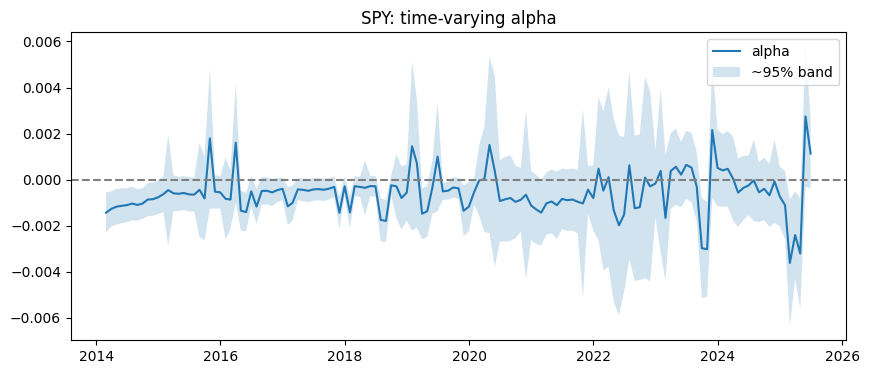

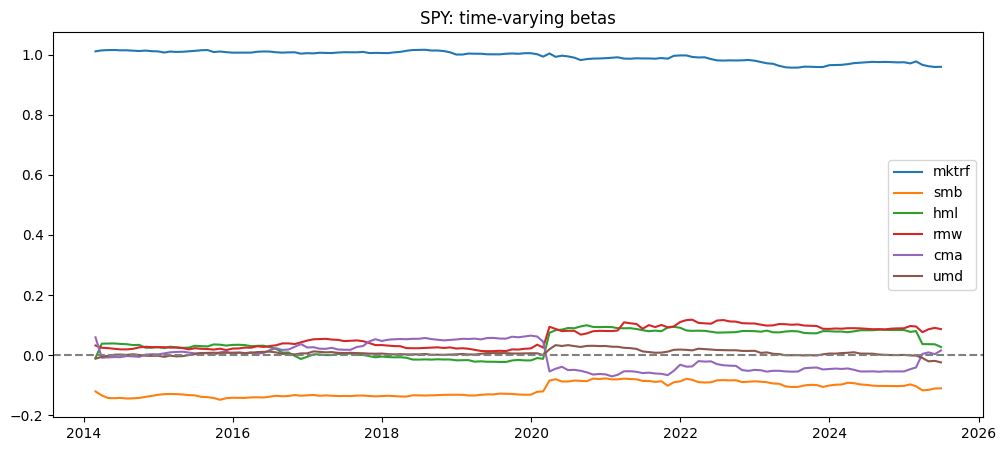

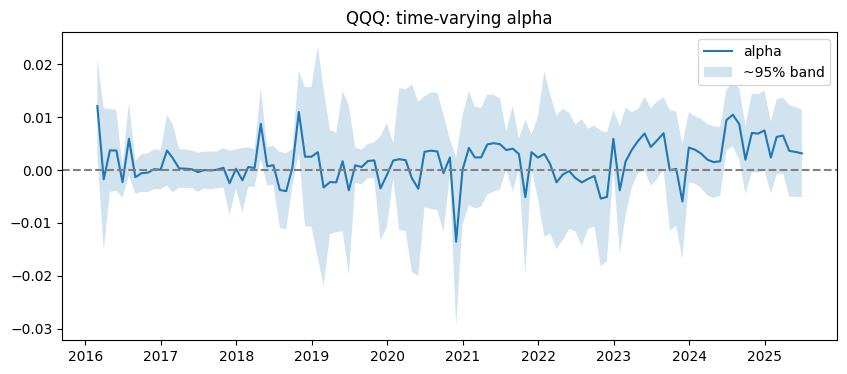

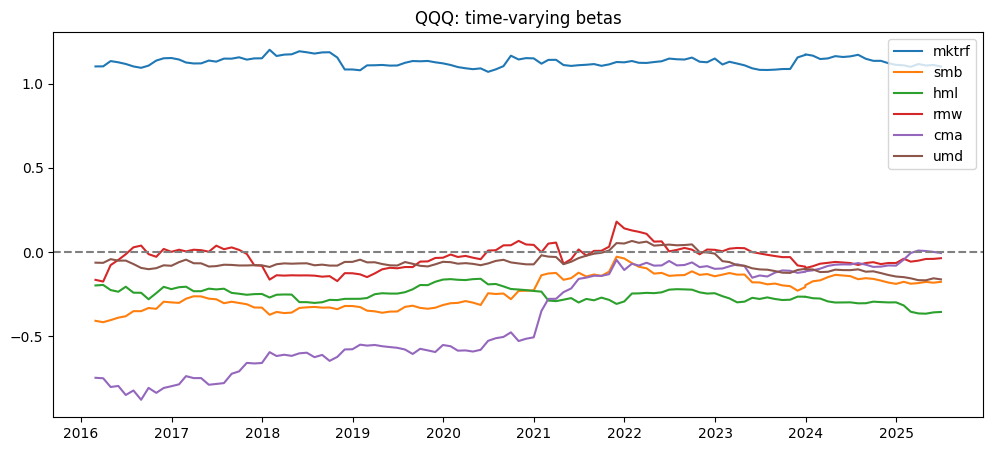

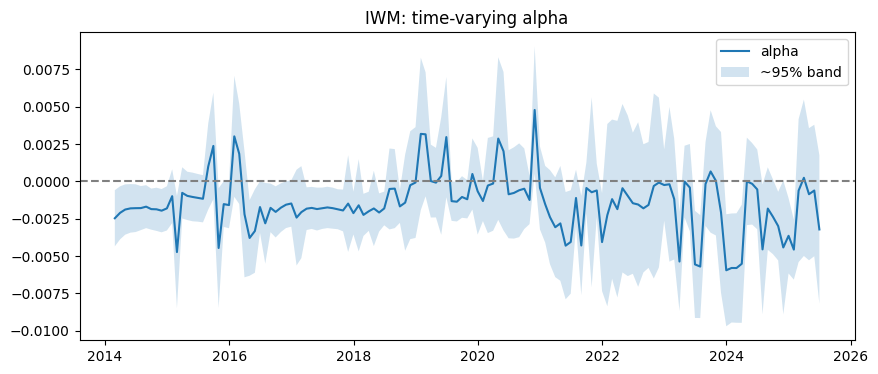

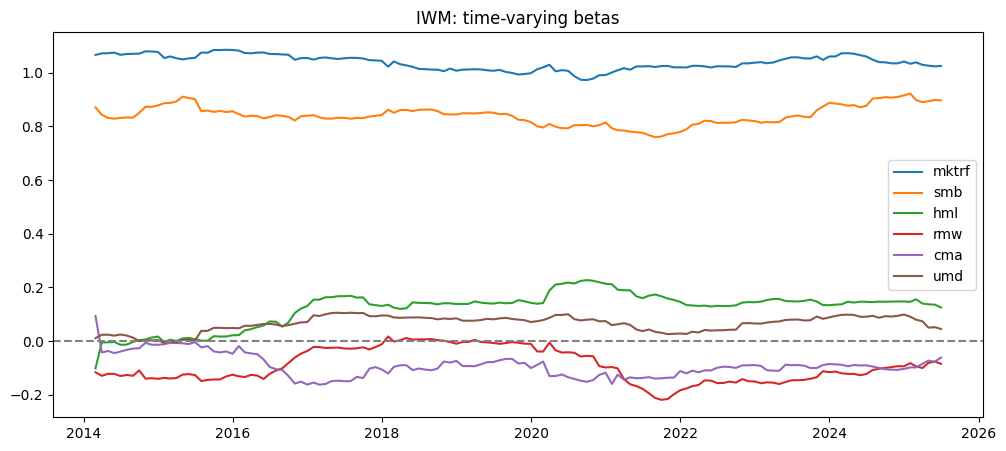

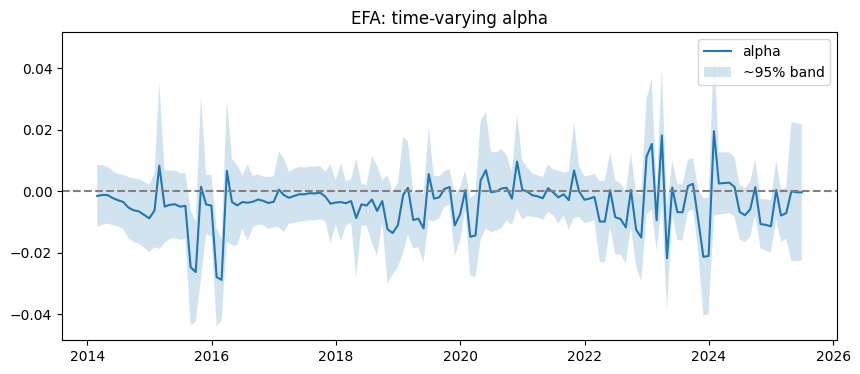

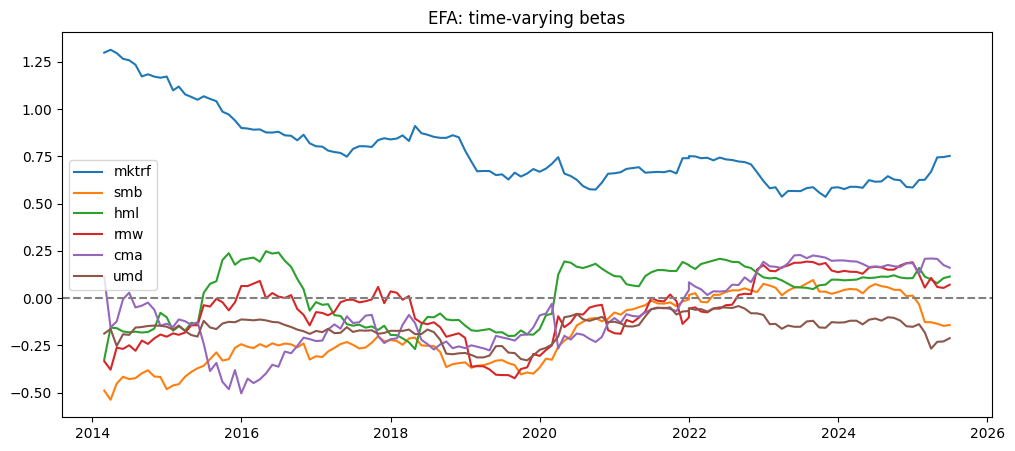

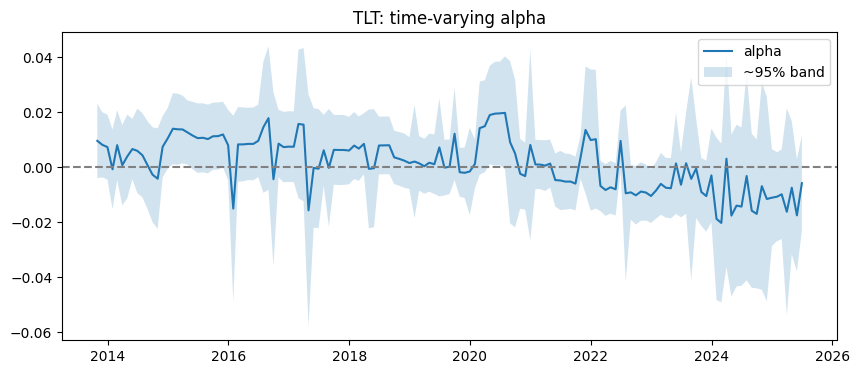

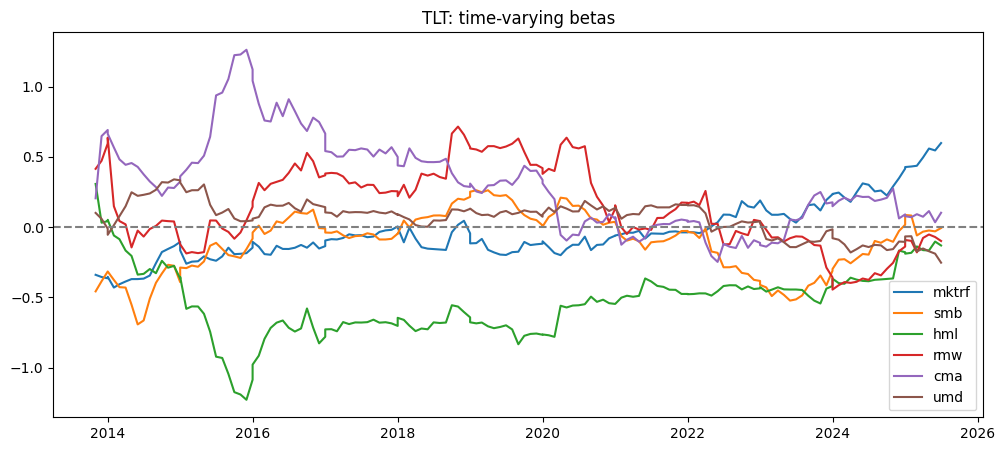

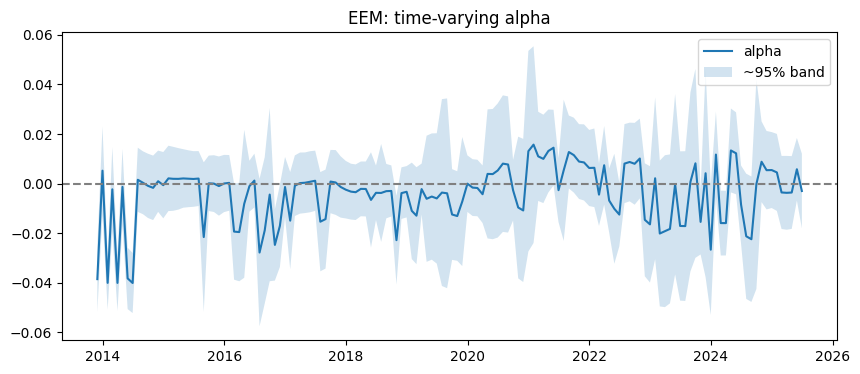

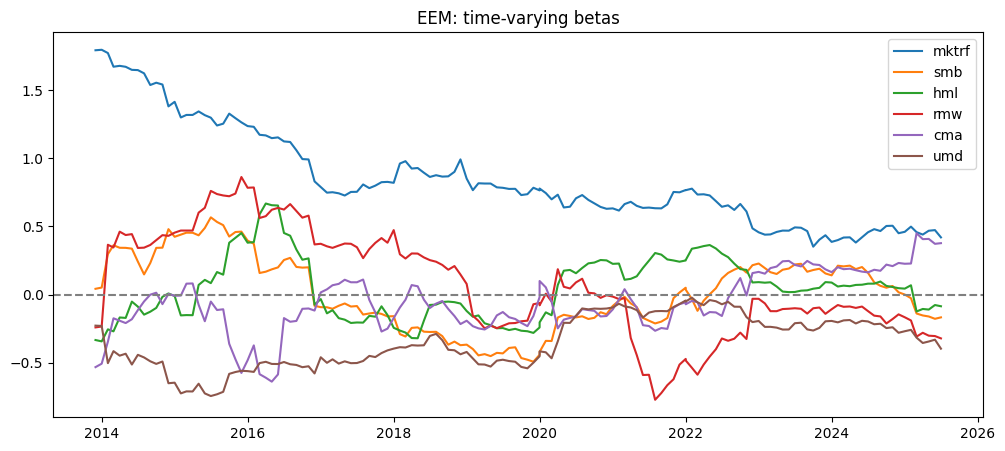

In [118]:
for tk in UNIVERSE:
    sig = alpha_signals[tk]
    plt.figure(figsize=(10,4))
    plt.plot(sig.index, sig['alpha'], label='alpha')
    up = sig['alpha'] + 1.96*sig['alpha_se']
    lo = sig['alpha'] - 1.96*sig['alpha_se']
    plt.fill_between(sig.index, lo, up, alpha=0.2, label='~95% band')
    plt.axhline(0, ls='--', c='gray'); plt.legend(); plt.title(f"{tk}: time-varying alpha")
    plt.show()

    bet = RESULTS[tk]['betas']
    if not bet.empty:
        plt.figure(figsize=(12,5))
        for c in FACTOR_COLS:
            s = bet[c].dropna()
            if len(s): plt.plot(s.index, s, label=c)
        plt.axhline(0, ls='--', c='gray'); plt.legend(); plt.title(f"{tk}: time-varying betas")
        plt.show()


In [119]:
# --- load daily ---
daily = pd.read_csv("DailyData.csv")

# Map CRSP-style columns explicitly
date_col   = 'DlyCalDt'
ticker_col = 'Ticker'
close_col  = 'DlyClose'      # no explicit open in your file
open_col   = None            # we'll proxy from first close in month

# Types
daily[date_col] = pd.to_datetime(daily[date_col])
daily = daily.rename(columns={ticker_col:'Ticker', close_col:'Close'})
if open_col and open_col in daily.columns:
    daily = daily.rename(columns={open_col:'Open'})
else:
    daily['Open'] = daily['Close']  # placeholder; we’ll take month-first

# universe filter (optional)
daily = daily[daily['Ticker'].isin(UNIVERSE)].copy()

# monthly first/last by ticker
daily = daily.sort_values([ 'Ticker', date_col ])
daily['M'] = daily[date_col].dt.to_period('M')

grp = daily.groupby(['Ticker','M'])
m_open  = grp['Open'].first()          # first trading day “open” proxy
m_close = grp['Close'].last()          # last trading day close

prices_open  = m_open.unstack('Ticker')
prices_close = m_close.unstack('Ticker')

# move to true month-end timestamps
prices_open.index  = prices_open.index.to_timestamp('M')
prices_close.index = prices_close.index.to_timestamp('M')

def get_open_prices(dt):
    s = prices_open.loc[dt].dropna()
    return {tk: float(s[tk]) for tk in s.index}

def get_close_prices(dt):
    s = prices_close.loc[dt].dropna()
    return {tk: float(s[tk]) for tk in s.index}


In [120]:
def estimate_per_side_bps_by_ticker_from_crsp(daily_df):
    """
    Estimate per-ticker per-side trading cost (bps) using Roll's effective spread.
    Expects columns: 'Ticker', 'DlyCalDt' (datetime-like), 'DlyClose'.
    """
    date_col = 'DlyCalDt'

    # sort & compute daily simple returns aligned to the original index
    dd = daily_df.sort_values(['Ticker', date_col]).copy()
    dd['ret'] = dd.groupby('Ticker')['Close'].transform(lambda s: s.pct_change())

    costs = {}
    for tk, sub in dd.groupby('Ticker'):
        r = sub['ret'].dropna()
        if len(r) < 40:
            continue  # not enough data to estimate reliably

        # Roll (1984) effective spread (in return units)
        cov1 = np.cov(r[1:], r[:-1])[0, 1]
        roll_eff_spread = 2.0 * np.sqrt(max(0.0, -cov1))
        half_spread_side = 0.5 * roll_eff_spread          # per side
        half_spread_bps  = half_spread_side * 10000.0

        commission_bps   = 3.0                              # small add-on
        per_side_bps     = half_spread_bps + commission_bps

        costs[tk] = per_side_bps

    return costs

cost_bps_by_ticker = estimate_per_side_bps_by_ticker_from_crsp(daily)
def per_side_bps(tk):  # helper/fallback
    return cost_bps_by_ticker.get(tk, 10.0)   # conservative default if missing

cost_bps_by_ticker

{'EEM': 47.8673036049191,
 'EFA': 41.876618915787915,
 'IWM': 40.80486159017342,
 'QQQ': 43.62490541326369,
 'SPY': 39.565181736656164,
 'TLT': 22.37950369873322}

In [121]:
#Convert Alpha signal to weights
def _alpha_at(sig: pd.DataFrame, when):
    # try exact match first
    try:
        row = sig.loc[when]
    except KeyError:
        return None

    # row can be Series (one row) or DataFrame (duplicates)
    if isinstance(row, pd.Series):
        # single row with both cols
        if 'alpha' in row and 'alpha_se' in row:
            return float(row['alpha']), float(row['alpha_se'])
        # single column selection fallback (shouldn’t happen here)
        return None
    else:
        # duplicate index → take the last row for that date
        r = row.iloc[-1]
        return float(r['alpha']), float(r['alpha_se'])

def _project_box_simplex(scores: dict[str, float], cap: float, total: float = 1.0) -> dict[str, float]:
    """
    Project nonnegative 'scores' onto {w | sum(w)=T, 0<=w<=cap}, with T=min(total, cap*K).
    Leaves cash if cap*K < total. Returns weights for the same keys (others 0).
    """
    # active (positive) names only
    keys = [k for k,v in scores.items() if v > 0]
    out  = {k: 0.0 for k in scores}
    if not keys:
        return out

    # target total mass (≤ 1 by default), limited by cap * number_of_actives
    T = min(float(total), cap * len(keys))
    if T <= 0:
        return out

    y = np.array([scores[k] for k in keys], dtype=float)
    y = y / y.sum()  # reference proportions

    # bisection on tau for x = clip(y - tau, 0, cap) to make sum(x)=T
    lo = y.min() - cap
    hi = y.max()
    for _ in range(80):
        tau = 0.5*(lo+hi)
        x = np.minimum(cap, np.maximum(0.0, y - tau))
        s = x.sum()
        if s > T:   # too much mass -> raise tau
            lo = tau
        else:
            hi = tau
    tau = 0.5*(lo+hi)
    x = np.minimum(cap, np.maximum(0.0, y - tau))  # sum(x) ≈ T

    for k, w in zip(keys, x):
        out[k] = float(w)
    return out

def weights_from_alpha(alpha_signals, when, cap=0.35, mode='tstat'):
    # build nonnegative scores from alpha or t-stat
    scores = {}
    for tk, sig in alpha_signals.items():
        try:
            row = sig.loc[when]
        except KeyError:
            continue
        a = float(row['alpha'])
        se = float(row['alpha_se'])
        s = (a/se) if (mode == 'tstat' and se > 0) else (a if mode == 'alpha' else 0.0)
        if s > 0:
            scores[tk] = s

    # no positive signals => all zero weights
    if not scores:
        return {tk: 0.0 for tk in UNIVERSE}

    # project with total=1 but allow cash if infeasible (handled inside)
    w = _project_box_simplex(scores, cap=cap, total=1.0)

    # ensure every name exists in the dict
    for tk in UNIVERSE:
        w.setdefault(tk, 0.0)
    return w

#If the alpha improvement is worth the cost of the trade, make the trade
def should_trade(prev_w, target_w, alpha_vector, cost_bps_by_tk, margin_bps=0.0):
    # align keys
    keys = set(prev_w) | set(target_w) | set(alpha_vector)
    dw   = {k: target_w.get(k,0.0) - prev_w.get(k,0.0) for k in keys}
    # expected alpha gain (monthly, in return units)
    exp_gain = sum(dw[k] * alpha_vector.get(k, 0.0) for k in keys)
    # turnover cost (per-side)
    cost = sum(abs(dw[k]) * (cost_bps_by_tk.get(k,10.0)/10000.0) for k in keys)
    # optional margin (buffer) in bps → decimal
    cost += margin_bps/10000.0
    return exp_gain > cost, exp_gain, cost

#Rebalance portfolio weights at next possible opening time
def rebalance_next_open_with_asset_costs(prev_shares, open_prices, target_weights, cash0, cost_bps_by_tk):
    pv_open = cash0 + sum(prev_shares.get(tk,0.0)*open_prices[tk] for tk in open_prices)
    tgt_dollars = {tk: target_weights.get(tk,0.0)*pv_open for tk in open_prices}
    cur_dollars = {tk: prev_shares.get(tk,0.0)*open_prices[tk] for tk in open_prices}
    trade_dollars = {tk: tgt_dollars[tk] - cur_dollars[tk] for tk in open_prices}
    # per-ticker costs
    cost = sum(abs(v) * (cost_bps_by_tk.get(tk,10.0)/10000.0) for tk,v in trade_dollars.items())
    # scale targets so total invested = PV - cost
    scale = (pv_open - cost) / max(pv_open, 1e-12)
    tgt_dollars = {tk: v*scale for tk,v in tgt_dollars.items()}
    # recompute trades (post-scale)
    trade_dollars = {tk: tgt_dollars[tk] - cur_dollars[tk] for tk in open_prices}
    new_shares = {tk: tgt_dollars[tk] / open_prices[tk] for tk in open_prices}
    cash1 = pv_open - sum(tgt_dollars.values())
    return new_shares, cash1, pv_open, trade_dollars, cost


In [122]:
# --------- PART F: RUN THE PORTFOLIO LOOP ---------
# Prereqs:
# - UNIVERSE list
# - alpha_signals: dict {tk: DataFrame with ['alpha','alpha_se'] indexed by month-end Timestamp}
# - prices_open, prices_close: DataFrames (index=month-end Timestamp, columns=tickers)
# - cost_bps_by_ticker: dict {tk: per-side bps}

def run_alpha_portfolio(alpha_signals,
                        prices_open, prices_close,
                        cost_bps_by_ticker,
                        start_cash=1_000_000.0,
                        cap=0.35, mode='tstat', margin_bps=0.0):
    # 1) common month-ends where we have alpha and prices
    dates_alpha = set().union(*[set(sig.index) for sig in alpha_signals.values()])
    dates_price = set(prices_open.index).intersection(set(prices_close.index))
    dates = sorted(dates_alpha.intersection(dates_price))
    if len(dates) < 2:
        raise ValueError("Not enough common dates between alpha and prices.")

    # 2) state variables
    shares = {tk: 0.0 for tk in UNIVERSE}
    cash   = float(start_cash)
    prev_w = {tk: 0.0 for tk in UNIVERSE}

    history = []   # list of dict rows (we’ll make a DataFrame at the end)

    # 3) main loop: decide @ t, trade @ t+1 open, hold to t+1 close
    for i in range(len(dates)-1):
        t      = dates[i]
        t_next = dates[i+1]

        # --- decide weights from alpha at t
        w_target = weights_from_alpha(alpha_signals, when=t, cap=cap, mode=mode)

        # alpha vector at t (per ticker)
        alpha_vec = {}
        for tk, sig in alpha_signals.items():
            if t in sig.index:
                alpha_vec[tk] = float(sig.loc[t, 'alpha'])

        # --- cost-aware decision: trade only if alpha gain > costs (+ optional margin)
        trade_ok, exp_gain, exp_cost = should_trade(prev_w, w_target, alpha_vec,
                                                    cost_bps_by_tk=cost_bps_by_ticker,
                                                    margin_bps=margin_bps)
        w_exec = w_target if trade_ok else prev_w

        # --- execute @ next open
        # get available open/close prices (drop NaNs safely)
        # --- inside run_alpha_portfolio(), right before executing the trade ---
            
        op_row = prices_open.loc[t_next].dropna()
        cl_row = prices_close.loc[t_next].dropna()
        tradable = sorted(set(op_row.index).intersection(set(UNIVERSE)))

        open_prices  = {tk: float(op_row[tk]) for tk in tradable}
        close_prices = {tk: float(cl_row[tk]) for tk in tradable}

        # re-project EXECUTED weights on tradables with the same cap
        # (sum to min(1, cap * K_tradable); leftover stays in cash)
        w_exec_tradable = {tk: max(0.0, float(w_exec.get(tk, 0.0))) for tk in tradable}
        w_exec_tradable = _project_box_simplex(w_exec_tradable, cap=cap, total=1.0)

        new_shares, cash_after, pv_open, trade_dollars, exec_cost = \
            rebalance_next_open_with_asset_costs(
                prev_shares=shares,
                open_prices=open_prices,
                target_weights=w_exec_tradable,
                cash0=cash,
                cost_bps_by_tk=cost_bps_by_ticker
            )

        # hold to close → portfolio value
        pv_close = cash_after + sum(new_shares.get(tk,0.0)*close_prices.get(tk, np.nan) for tk in tradable)

        # realized weights at close (for next iteration's 'prev_w')
        total_close = pv_close if pv_close != 0 else 1.0
        realized_w = {tk: (new_shares.get(tk,0.0)*close_prices.get(tk, np.nan))/total_close
                      for tk in tradable}

        # compute gross turnover (|$ trades| / PV_open) and $ turnover
        dollar_turnover = sum(abs(v) for v in trade_dollars.values())
        turnover = dollar_turnover / max(pv_open, 1e-12)

        # store & advance state
        history.append({
            'date'        : t_next,
            'pv_open'     : pv_open,
            'pv_close'    : pv_close,
            'ret_net'     : (pv_close / pv_open - 1.0) if pv_open > 0 else 0.0,
            'trade_ok'    : trade_ok,
            'exp_gain'    : exp_gain,    # expected alpha gain used in the gate
            'exp_cost'    : exp_cost,    # expected turnover cost in return units
            'exec_cost_$' : exec_cost,   # actual $ cost charged at the open
            'turnover'    : turnover,
            'turnover_$'  : dollar_turnover,
            'w_target'    : w_target,
            'w_exec'      : w_exec,
            'w_realized'  : realized_w
        })

        # advance state for next step
        shares = new_shares
        cash   = cash_after
        prev_w = realized_w

    # 4) assemble results
    port = pd.DataFrame(history).set_index('date').sort_index()
    port['equity'] = port['pv_close']
    port['cum_ret'] = (1 + port['ret_net']).cumprod() - 1.0
    return port


                 pv_open      pv_close   ret_net  turnover  exec_cost_$
date                                                                   
2025-02-28  2.396994e+06  2.396609e+06 -0.000161  0.000066     0.694644
2025-03-31  2.360147e+06  2.317338e+06 -0.018138  0.025670   277.153966
2025-04-30  2.330168e+06  2.334869e+06  0.002017  0.036748   391.658897
2025-05-31  2.349907e+06  2.488737e+06  0.059079  0.010435   112.257542
2025-06-30  2.507600e+06  2.641074e+06  0.053228  0.017907   205.439704


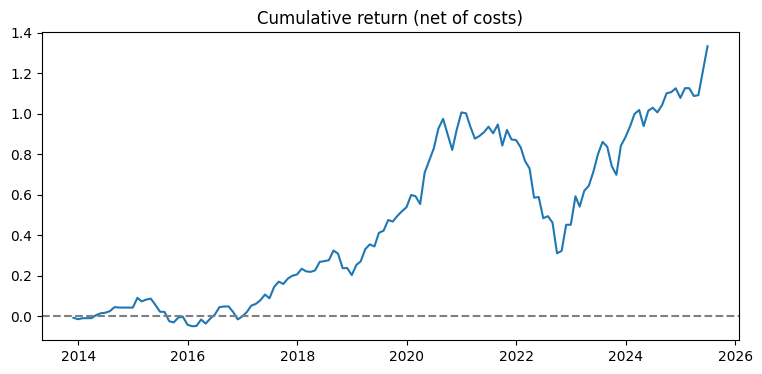

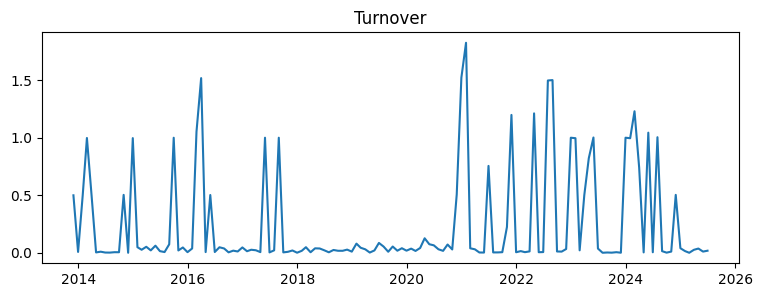

In [125]:
# Example call (assuming you already built these objects):
# - alpha_signals: dict of DataFrames with ['alpha','alpha_se'] by ticker
# - prices_open, prices_close: monthly open/close (from DailyData.csv)
# - cost_bps_by_ticker: dict of per-side bps (estimated with Roll)

port_hist = run_alpha_portfolio(
    alpha_signals=alpha_signals,
    prices_open=prices_open,
    prices_close=prices_close,
    cost_bps_by_ticker=cost_bps_by_ticker,
    start_cash=1_000_000.0,
    cap=0.5,
    mode='tstat',       # or 'alpha'
    margin_bps=0.0      # add a buffer if you want fewer tiny trades
)

# Quick sanity checks:
print(port_hist[['pv_open','pv_close','ret_net','turnover','exec_cost_$']].tail())

# Example plots:
plt.figure(figsize=(9,4)); plt.plot(port_hist.index, port_hist['cum_ret']); 
plt.title('Cumulative return (net of costs)'); plt.axhline(0, ls='--', c='gray'); plt.show()

plt.figure(figsize=(9,3)); plt.plot(port_hist.index, port_hist['turnover']); 
plt.title('Turnover'); plt.show()


In [ ]:
mret = port_hist['ret_net'].dropna()
T = len(mret)

# Cumulative return series (you already plotted cum_ret)
cum = (1 + mret).cumprod() - 1

# CAGR (from start to end), annualized vol, Sharpe (using RF if you have it)
years = T / 12.0
cagr  = (1 + cum.iloc[-1])**(1/years) - 1
ann_vol = mret.std() * np.sqrt(12)

# If you have a monthly risk-free rate series aligned to port_hist index:
# rf_m ~ monthly decimal rate; else set to 0 for plain Sharpe
try:
    rf_m = ff_monthly.set_index('MthCalDt')['rf'].reindex(mret.index).fillna(0.0)
except Exception:
    rf_m = pd.Series(0.0, index=mret.index)

excess = mret - rf_m
ann_excess_ret = excess.mean() * 12
sharpe = (excess.mean() / excess.std()) * np.sqrt(12) if excess.std() > 0 else np.nan

print(f"CAGR: {cagr:.3%}")
print(f"Annualized vol: {ann_vol:.2%}")
print(f"Annualized excess return: {ann_excess_ret:.2%}")
print(f"Sharpe (excess/vol): {sharpe:.2f}")


CAGR: 7.531%
Annualized vol: 11.21%
Annualized excess return: 6.30%
Sharpe (excess/vol): 0.57


Real CAGR (deflated by CPI or RF proxy): 5.819%


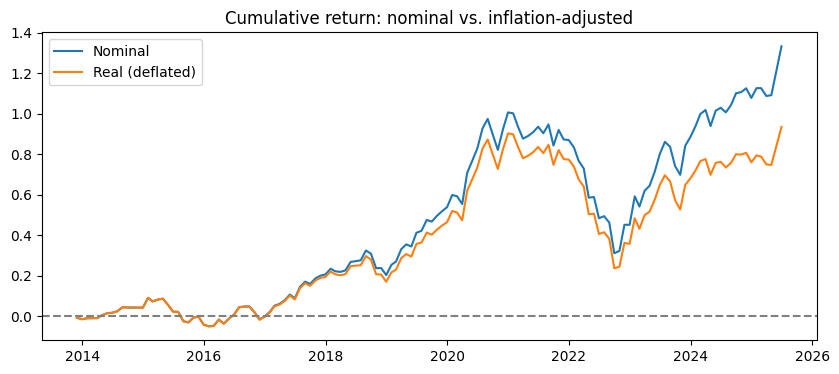

In [130]:
# Suppose cpi_df has columns ['date','CPI'] at month-end timestamps
# cpi_df['date'] = pd.to_datetime(cpi_df['date']); cpi_df = cpi_df.set_index('date').sort_index()
# monthly inflation rate:
# inf_m = cpi_df['CPI'].pct_change().reindex(mret.index).fillna(0.0)

# If you *don’t* have CPI, a very rough proxy is to use monthly RF as an approximation
# of expected inflation over very short horizons (not ideal, but better than nothing):
inf_m = rf_m.copy()  # crude proxy if CPI not available

# Real monthly return: (1+r) / (1+infl) - 1
real_mret = ((1 + mret) / (1 + inf_m)) - 1
real_cum  = (1 + real_mret).cumprod() - 1
real_cagr = (1 + real_cum.iloc[-1])**(1/years) - 1

print(f"Real CAGR (deflated by CPI or RF proxy): {real_cagr:.3%}")

# Plot nominal vs real cumulative
plt.figure(figsize=(10,4))
plt.plot(cum.index, cum.values, label='Nominal')
plt.plot(real_cum.index, real_cum.values, label='Real (deflated)')
plt.axhline(0, ls='--', c='gray'); plt.legend()
plt.title("Cumulative return: nominal vs. inflation-adjusted")
plt.show()


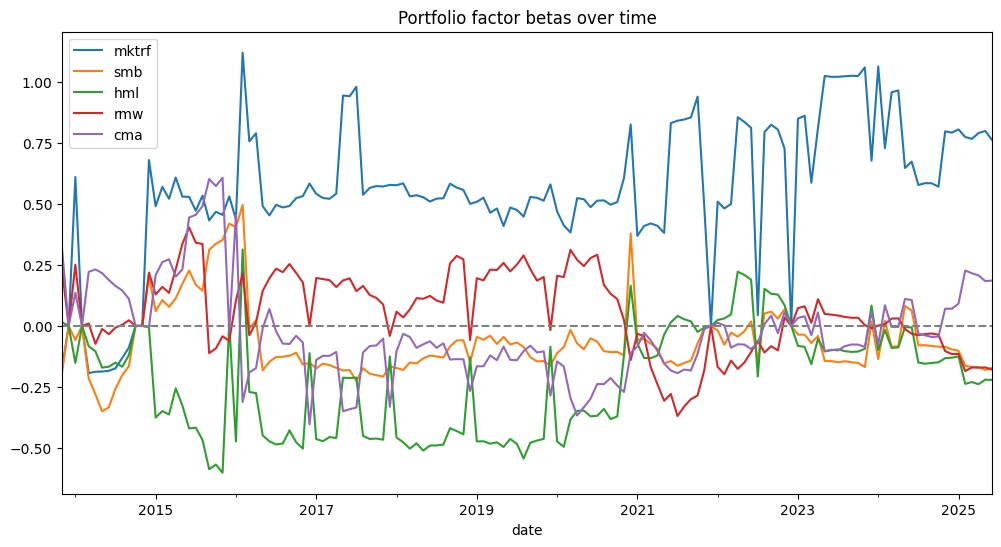

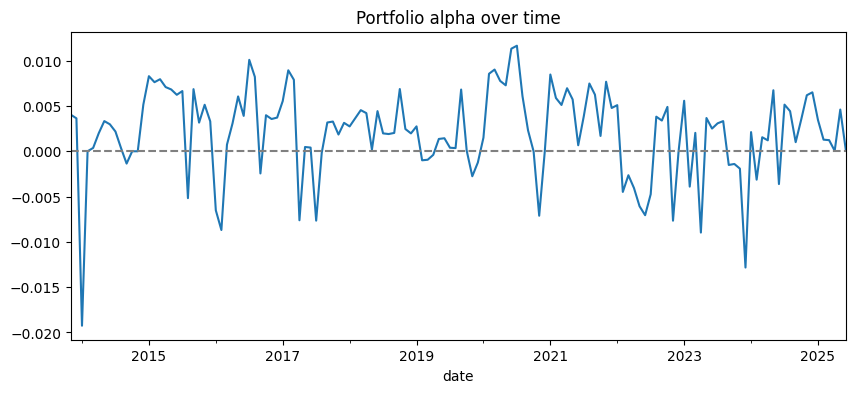

In [139]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FACTORS = ['mktrf','smb','hml','rmw','cma']  # match your RESULTS[...] columns

def portfolio_factor_series(port_hist, alpha_signals, RESULTS, factors=FACTORS, use='w_realized'):
    """
    Build portfolio alpha and factor-betas as weight-averages of asset series.
      port_hist: DataFrame with a weights column ('w_realized' or 'w_exec') that stores dicts {ticker: weight}
      alpha_signals: dict[ticker] -> DataFrame with column 'alpha'
      RESULTS: dict[ticker]['betas'] -> DataFrame with factor columns in `factors`
      factors: list of factor names to aggregate
      use: 'w_realized' (default) or 'w_exec'
    Returns: DataFrame indexed by date with columns `factors` + ['alpha'] as floats.
    """
    out_rows = []
    idx = []

    # sanity: ensure the weights column exists
    if use not in port_hist.columns:
        raise KeyError(f"{use} not found in port_hist columns: {list(port_hist.columns)}")

    for dt, row in port_hist.iterrows():
        w = row[use]
        if not isinstance(w, dict) or len(w) == 0:
            # store NaNs to keep alignment; will be dropped in plot if needed
            out_rows.append({**{f: np.nan for f in factors}, 'alpha': np.nan})
            idx.append(dt)
            continue

        vals = {f: 0.0 for f in factors}
        vals['alpha'] = 0.0

        for tk, wi in w.items():
            # add alpha
            try:
                ai = float(alpha_signals[tk].loc[dt, 'alpha'])
                vals['alpha'] += wi * ai
            except Exception:
                pass  # missing alpha at this dt

            # add factor betas
            try:
                b = RESULTS[tk]['betas']
                if dt in b.index:
                    for f in factors:
                        if f in b.columns:
                            vals[f] += wi * float(b.loc[dt, f])
            except Exception:
                pass  # missing betas

        out_rows.append(vals)
        idx.append(dt)

    pf = pd.DataFrame(out_rows, index=pd.Index(idx, name='date'))
    # ensure numeric dtype
    for c in pf.columns:
        pf[c] = pd.to_numeric(pf[c], errors='coerce')
    return pf

# ---- build the series
port_factors = portfolio_factor_series(port_hist, alpha_signals, RESULTS, factors=FACTORS, use='w_realized')

# Drop rows where everything is NaN (no weights or no inputs that month)
port_factors = port_factors.dropna(how='all')

# ---- plots
ax = port_factors[FACTORS].plot(figsize=(12,6), title="Portfolio factor betas over time")
ax.axhline(0, ls='--', c='gray')
plt.show()

ax = port_factors['alpha'].plot(figsize=(10,4), title="Portfolio alpha over time")
ax.axhline(0, ls='--', c='gray')
plt.show()


In [ ]:
for tk in UNIVERSE:
    sig = alpha_signals[tk]
    plt.figure(figsize=(10,4))
    plt.plot(sig.index, sig['alpha'], label='alpha')
    up = sig['alpha'] + 1.96*sig['alpha_se']
    lo = sig['alpha'] - 1.96*sig['alpha_se']
    plt.fill_between(sig.index, lo, up, alpha=0.2, label='~95% band')
    plt.axhline(0, ls='--', c='gray'); plt.legend(); plt.title(f"{tk}: time-varying alpha")
    plt.show()

    bet = RESULTS[tk]['betas']
    if not bet.empty:
        plt.figure(figsize=(12,5))
        for c in FACTOR_COLS:
            s = bet[c].dropna()
            if len(s): plt.plot(s.index, s, label=c)
        plt.axhline(0, ls='--', c='gray'); plt.legend(); plt.title(f"{tk}: time-varying betas")
        plt.show()




In [137]:
RESULTS['SPY']['betas']

,mktrf,smb,hml,rmw,cma,umd
MthCalDt,,,,,,
2014-02-28,1.011833,-0.121431,-0.009571,0.031598,0.058923,-0.012352
2014-03-31,1.015039,-0.134907,0.037698,0.024078,-0.009016,-0.006076
2014-04-30,1.015927,-0.143129,0.037927,0.022824,-0.007806,-0.002595
2014-05-31,1.016270,-0.144012,0.038482,0.020758,-0.006919,0.000697
2014-06-30,1.015101,-0.142972,0.036781,0.018581,-0.007265,0.001548
...,...,...,...,...,...,...
2025-02-28,0.978285,-0.104227,0.079678,0.094791,-0.041639,-0.002012
2025-03-31,0.966680,-0.117740,0.036369,0.076035,0.003406,-0.009997
2025-04-30,0.962258,-0.116402,0.036049,0.085614,0.008653,-0.021196
